In [1]:
!pwd

/Users/gimbogeun/Segemtation_study/BG


0. 각종 사용자 변수 정의
1. 이미지 확인
2. 마스크 확인
3. 마스크를 학습용 마스크로 변환
4. 변환된 마스크 확인
5. 

In [1]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import cv2
import tensorflow as tf
import glob

### 0. 각종 사용자 변수 정의

In [2]:
VOC_COLORMAP = [[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0],
                [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128],
                [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0],
                [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
                [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0],
                [0, 64, 128]]

VOC_CLASSES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'potted plant', 'sheep', 'sofa', 'train', 'tv/monitor']

## 의문 ##
# 엣지 클래스도 넣어야하는거 아닌가..???

In [19]:
BATCH_SIZE = 8
IMG_SIZE = (256, 256)


image_dataset_path = '/Users/gimbogeun/Downloads/DATASETS/VOCdevkit/VOC2012/SegmentationDatasets/image'
gt_dataset_path = '/Users/gimbogeun/Downloads/DATASETS/VOCdevkit/VOC2012/SegmentationClass'
print(len(os.listdir(image_dataset_path)))
print(len(os.listdir(gt_dataset_path)))
img1_name = '2011_002135.jpg'
gt1_name = '2011_002135.png'
img1_path = os.path.join(image_dataset_path, img1_name)
gt1_path = os.path.join(gt_dataset_path, gt1_name)

2913
2913


In [4]:
def img_show(path):
    # img = plt.imread(path)
    # img1 = plt.imshow(img)
    img = cv2.imread(path)
    img1 = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # 무조건 RGB로 읽어야 VOC_CLASSES랑 매치가 가능함. Image.open으로 파일 열고 np.array화해서 보면 클래스 세부내용 확인가능.
    plt.imshow(img1)
    print(img1.shape)

In [5]:
def display_multiple_img(mask1, VOC_CLASSES, rows = 1, cols=1):
    figure, ax = plt.subplots(nrows=rows, ncols=cols)
    for label, i in zip(VOC_CLASSES, range(rows*cols)):
#         print(label)
        ax.ravel()[i].imshow(mask1[:,:,i], cmap='gray')
        ax.ravel()[i].set_title(label)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

def mk_seg_mask(gt_path, VOC_COLORMAP):
    gt1_cv2 = cv2.imread(gt_path)
    mask = cv2.cvtColor(gt1_cv2, cv2.COLOR_BGR2RGB)
    height, width = mask.shape[:2]
    segmentation_mask = np.zeros((height, width, len(VOC_COLORMAP)), dtype=np.float32)
    for label_index, label in enumerate(VOC_COLORMAP):
    #     print(label_index, label)
        segmentation_mask[:, :, label_index] = np.all(mask == label, axis=-1).astype(float)
    return segmentation_mask

In [10]:
img_dataset_abspath = sorted(glob.glob(os.path.join(image_dataset_path, '*')))
mask_dataset_abspath = sorted(glob.glob(os.path.join(gt_dataset_path, '*')))
print(f'이미지 갯수 : {len(img_dataset_abspath)}')
print(f'마스크 갯수 : {len(mask_dataset_abspath)}')
print(list(map(os.path.basename, img_dataset_abspath))[:3])
print(list(map(os.path.basename, mask_dataset_abspath))[:3])

이미지 갯수 : 2913
마스크 갯수 : 2913
['2007_000032.jpg', '2007_000033.jpg', '2007_000039.jpg']
['2007_000032.png', '2007_000033.png', '2007_000039.png']


In [106]:
def img_mask_set(img_path, mask_path, VOC_COLORMAP):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE[0], IMG_SIZE[1]), cv2.INTER_LINEAR)/255
    img = np.array(img, dtype=np.float32)
    
    mask = cv2.imread(mask_path)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
    mask = cv2.resize(mask, (IMG_SIZE[0], IMG_SIZE[1]), cv2.INTER_LINEAR)
    
#     print(mask.shape)
#     print(mask.dtype)
    height, width = mask.shape[:2]
    segmentation_mask = np.zeros((height, width, len(VOC_COLORMAP)), dtype=np.float32)
    for label_index, label in enumerate(VOC_COLORMAP):
        segmentation_mask[:, :, label_index] = np.all(mask == label, axis=-1).astype(float)
    
    mask = np.array(mask/255, dtype=np.float32)
    
    return img, segmentation_mask, mask

In [107]:
img1, seg_mask1, mask1 = img_mask_set(img_dataset_abspath[0], mask_dataset_abspath[0], VOC_COLORMAP)
img1.shape, seg_mask1.shape, mask1.shape

((256, 256, 3), (256, 256, 21), (256, 256, 3))

In [109]:
img1.dtype, mask1.dtype

(dtype('float32'), dtype('float32'))

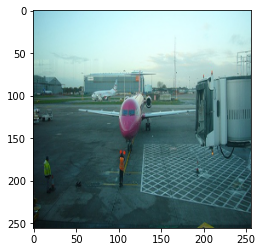

In [110]:
plt.imshow(img1)

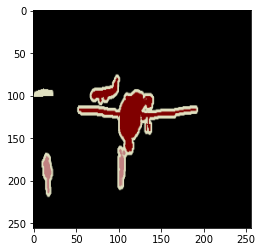

In [111]:
plt.imshow(mask1)

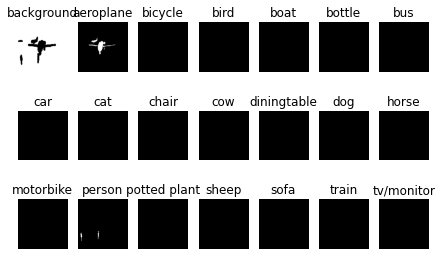

In [112]:
display_multiple_img(seg_mask1, VOC_CLASSES, 3, 7)

In [126]:
def dataset(img_dataset_abspath, mask_dataset_abspath, start_cnt, BATCH_SIZE):
#     start_cnt = 0

    batch_img = np.empty((BATCH_SIZE, IMG_SIZE[0], IMG_SIZE[1], 3))
    batch_seg_mask = np.empty((BATCH_SIZE, IMG_SIZE[0], IMG_SIZE[1], len(VOC_CLASSES)))
    batch_mask = np.empty((BATCH_SIZE, IMG_SIZE[0], IMG_SIZE[1], 3))

    batch_img_path = img_dataset_abspath[start_cnt:BATCH_SIZE]
    batch_seg_mask_path = mask_dataset_abspath[start_cnt:BATCH_SIZE]

    for bat in range(BATCH_SIZE):
        img_b, seg_mask_b, mask_b = img_mask_set(batch_img_path[bat], batch_mask_path[bat], VOC_COLORMAP)
        batch_img[bat] = img_b
        batch_seg_mask[bat] = seg_mask_b
        batch_mask[bat] = mask_b
        
    return batch_img, batch_seg_mask, batch_mask

## 모델 정의

In [131]:
!pip install -q git+https://github.com/tensorflow/examples.git

  DEPRECATION: tensorflow-examples was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/issues/8368.


In [132]:
from tensorflow_examples.models.pix2pix import pix2pix

# import tensorflow_datasets as tfds
# tfds.disable_progress_bar()

from IPython.display import clear_output
import matplotlib.pyplot as plt

In [133]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[256, 256, 3], include_top=False)

#이 층들의 활성화를 이용합시다
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# 특징추출 모델을 만듭시다
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

In [134]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [135]:
def unet_model(output_channels):
    inputs = tf.keras.layers.Input(shape=[128, 128, 3])
    x = inputs

    # 모델을 통해 다운샘플링합시다
    skips = down_stack(x)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # 건너뛰기 연결을 업샘플링하고 설정하세요
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    # 이 모델의 마지막 층입니다
    last = tf.keras.layers.Conv2DTranspose(
        output_channels, 3, strides=2,
        padding='same')  #64x64 -> 128x128

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [139]:
model = unet_model(21)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [149]:
tf.keras.utils.plot_model(model, show_shapes=True)


Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [150]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [151]:
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask, create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [153]:
show_predictions()

NameError: name 'sample_image' is not defined

In [121]:
start_cnt = 0

batch_img = np.empty((BATCH_SIZE, IMG_SIZE[0], IMG_SIZE[1], 3))
batch_seg_mask = np.empty((BATCH_SIZE, IMG_SIZE[0], IMG_SIZE[1], len(VOC_CLASSES)))
batch_mask = np.empty((BATCH_SIZE, IMG_SIZE[0], IMG_SIZE[1], 3))

batch_img_path = img_dataset_abspath[start_cnt:BATCH_SIZE]
batch_seg_mask_path = mask_dataset_abspath[start_cnt:BATCH_SIZE]

for bat in range(BATCH_SIZE):
    img_b, seg_mask_b, mask_b = img_mask_set(batch_img_path[bat], batch_mask_path[bat], VOC_COLORMAP)
    batch_img[bat] = img_b
    batch_seg_mask[bat] = seg_mask_b
    batch_mask[bat] = mask_b

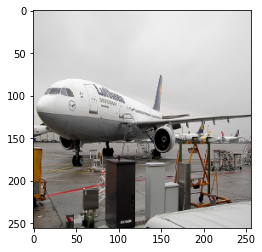

In [122]:
plt.imshow(batch_img[1])

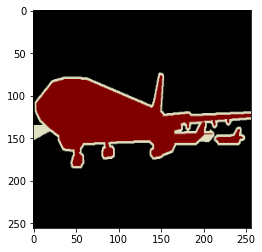

In [125]:
plt.imshow(batch_mask[1])

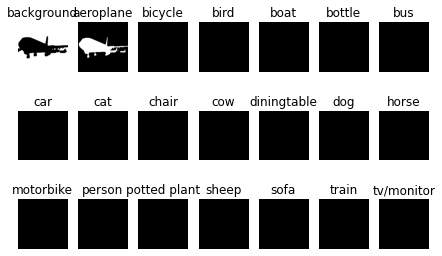

In [124]:
display_multiple_img(batch_seg_mask[1], VOC_CLASSES, 3, 7)

In [44]:
def mk_seg_mask_1(gt_tensor):
    img = tf.io.read_file(gt_path)# tf.Tensor: id=1, shape=(), dtype=string, numpy=b'\xff\xd8\xff\xe0\ ..
    img = tf.image.decode_jpeg(img, channels=3) # <tf.Tensor: id=4, shape=(500, 466, 3), dtype=uint8, numpy= array([[[ 95,  28,  11], ...
    img = tf.image.convert_image_dtype(img, tf.float32) # <tf.Tensor: id=10, shape=(500, 466, 3), dtype=float32, numpy=array([[[0.37254903, 0.10980393, 0.04313726],
    img = tf.image.resize(img, [IMG_SIZE[0], IMG_SIZE[1]]) # <tf.Tensor: id=21, shape=(IMG_SIZE[0], IMG_SIZE[1], 3), dtype=float32, numpy=array([[[0.36199272, 0.08055887, 0.06435176],
    
    mask = np.array(img)
    height, width = mask.shape[:2]
    segmentation_mask = np.zeros((height, width, len(VOC_COLORMAP)), dtype=np.float32)
    for label_index, label in enumerate(VOC_COLORMAP):
    #     print(label_index, label)
        segmentation_mask[:, :, label_index] = np.all(mask == label, axis=-1).astype(float)
    
    return tf.tensor(segmentation_mask)

In [91]:
def process_path1(img_path1):
    img = tf.io.read_file(img_path)# tf.Tensor: id=1, shape=(), dtype=string, numpy=b'\xff\xd8\xff\xe0\ ..
    img = tf.image.decode_jpeg(img, channels=3) # <tf.Tensor: id=4, shape=(500, 466, 3), dtype=uint8, numpy= array([[[ 95,  28,  11], ...
    img = tf.image.convert_image_dtype(img, dtype=tf.uint8) # <tf.Tensor: id=10, shape=(500, 466, 3), dtype=float32, numpy=array([[[0.37254903, 0.10980393, 0.04313726],
    img = tf.image.resize(img, [IMG_SIZE[0], IMG_SIZE[1]]) # <tf.Tensor: id=21, shape=(256, 256, 3), dtype=float32, numpy=array([[[0.36199272, 0.08055887, 0.06435176],
    return img


In [100]:
asd = tf.data.Dataset.list_files(os.path.join(gt_dataset_path, '*'), shuffle=False)
img = tf.io.read_file(next(iter(asd)))# tf.Tensor: id=1, shape=(), dtype=string, numpy=b'\xff\xd8\xff\xe0\ ..
img = tf.image.decode_jpeg(img, channels=3) # <tf.Tensor: id=4, shape=(500, 466, 3), dtype=uint8, numpy= array([[[ 95,  28,  11], ...
img = tf.image.resize(img, [IMG_SIZE[0], IMG_SIZE[1]]) # <tf.Tensor: id=21, shape=(256, 256, 3), dtype=float32, numpy=array([[[0.36199272, 0.08055887, 0.06435176],
img

<tf.Tensor: id=8883, shape=(256, 256, 3), dtype=float32, numpy=
array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]], dtype=float32)>

In [92]:
gt_ds = tf.data.Dataset.list_files(os.path.join(gt_dataset_path, '*'), shuffle=False)
gt_ds1 = gt_ds.map(process_path1)
gt_ds2 = configure_for_performance(gt_ds1, batch_size=8, buffer_size=1024)
gt_ds2

<DatasetV1Adapter shapes: (None, 256, 256, 3), types: tf.float32>

## 문제상황

1. 마스크를 학습용으로 변환하는데에 있어 텐서플로 data API가 잘 적용되지 않음.. 해결방법이 있을까..?
    1) 마스크를 넘파이로 변경해서 컬러맵과 매핑을 해야하는데 텐서형태에서의 맵핑과정에서 문제가 있는듯..
    2) 이미지 리사이즈하면서 dtype이 변경되면서 매핑이 안되는 것 같기도 함..
2. 순수 numpy 형태로 학습가능하지만, 텐서플로와 호환성이 떨어져 학습속도가 느려질 수 있음.. 하지만 이게 현재 가장 확실한 방법이긴 함
3. 

## 새로 알게된 사실

1. tf.image.resize를 하면 알아서 dtype이 tf.float32로 변경된다.
2. 

In [55]:
gt_ds2_batch = next(iter(gt_ds2))
gt_ds2_batch

<tf.Tensor: id=343, shape=(8, 256, 256, 3), dtype=float32, numpy=
array([[[[0.       , 0.       , 0.       ],
         [0.       , 0.       , 0.       ],
         [0.       , 0.       , 0.       ],
         ...,
         [0.       , 0.       , 0.       ],
         [0.       , 0.       , 0.       ],
         [0.       , 0.       , 0.       ]],

        [[0.       , 0.       , 0.       ],
         [0.       , 0.       , 0.       ],
         [0.       , 0.       , 0.       ],
         ...,
         [0.       , 0.       , 0.       ],
         [0.       , 0.       , 0.       ],
         [0.       , 0.       , 0.       ]],

        [[0.       , 0.       , 0.       ],
         [0.       , 0.       , 0.       ],
         [0.       , 0.       , 0.       ],
         ...,
         [0.       , 0.       , 0.       ],
         [0.       , 0.       , 0.       ],
         [0.       , 0.       , 0.       ]],

        ...,

        [[0.       , 0.       , 0.       ],
         [0.       , 0.       , 0.  

In [76]:
mask[0]

<tf.Tensor: id=8435, shape=(256, 256, 3), dtype=float32, numpy=
array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]], dtype=float32)>

In [75]:
gt_ds2_batch = next(iter(gt_ds2))
mask = gt_ds2_batch
batch, height, width = mask.shape[:3]
segmentation_mask = np.zeros((batch, height, width, len(VOC_COLORMAP)), dtype=np.float32)

for bat in range(batch):
    print(bat)
    for label_index, label in enumerate(VOC_COLORMAP):
#         print(label_index, label)
        segmentation_mask[bat][:, :, label_index] = np.all(mask[bat] == label, axis=-1).astype(float)
        print(segmentation_mask[bat].shape)
        print(mask[bat].shape)
        print(label)
segmentation_mask.shape

0
(256, 256, 21)
(256, 256, 3)
(256, 256, 21)
(256, 256, 3)
(256, 256, 21)
(256, 256, 3)
(256, 256, 21)
(256, 256, 3)
(256, 256, 21)
(256, 256, 3)
(256, 256, 21)
(256, 256, 3)
(256, 256, 21)
(256, 256, 3)
(256, 256, 21)
(256, 256, 3)
(256, 256, 21)
(256, 256, 3)
(256, 256, 21)
(256, 256, 3)
(256, 256, 21)
(256, 256, 3)
(256, 256, 21)
(256, 256, 3)
(256, 256, 21)
(256, 256, 3)
(256, 256, 21)
(256, 256, 3)
(256, 256, 21)
(256, 256, 3)
(256, 256, 21)
(256, 256, 3)
(256, 256, 21)
(256, 256, 3)
(256, 256, 21)
(256, 256, 3)
(256, 256, 21)
(256, 256, 3)
(256, 256, 21)
(256, 256, 3)
(256, 256, 21)
(256, 256, 3)
1
(256, 256, 21)
(256, 256, 3)
(256, 256, 21)
(256, 256, 3)
(256, 256, 21)
(256, 256, 3)
(256, 256, 21)
(256, 256, 3)
(256, 256, 21)
(256, 256, 3)
(256, 256, 21)
(256, 256, 3)
(256, 256, 21)
(256, 256, 3)
(256, 256, 21)
(256, 256, 3)
(256, 256, 21)
(256, 256, 3)
(256, 256, 21)
(256, 256, 3)
(256, 256, 21)
(256, 256, 3)
(256, 256, 21)
(256, 256, 3)
(256, 256, 21)
(256, 256, 3)
(256, 256,

(8, 256, 256, 21)

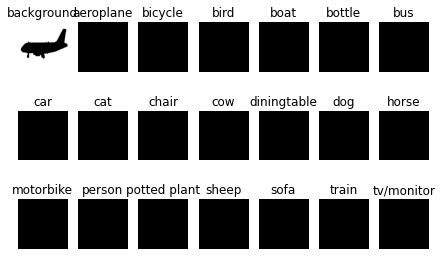

In [70]:
display_multiple_img(segmentation_mask[3], VOC_CLASSES, 3, 7)

In [42]:
img = next(iter(gt_ds))
img = tf.io.read_file(img)# tf.Tensor: id=1, shape=(), dtype=string, numpy=b'\xff\xd8\xff\xe0\ ..
img = tf.image.decode_jpeg(img, channels=3) # <tf.Tensor: id=4, shape=(500, 466, 3), dtype=uint8, numpy= array([[[ 95,  28,  11], ...
img = tf.image.convert_image_dtype(img, tf.float32) # <tf.Tensor: id=10, shape=(500, 466, 3), dtype=float32, numpy=array([[[0.37254903, 0.10980393, 0.04313726],
img = tf.image.resize(img, [IMG_SIZE[0], IMG_SIZE[1]]) # <tf.Tensor: id=21, shape=(IMG_SIZE[0], IMG_SIZE[1], 3), dtype=float32, numpy=array([[[0.36199272, 0.08055887, 0.06435176],

mask = np.array(img)
height, width = mask.shape[:2]
segmentation_mask = np.zeros((height, width, len(VOC_COLORMAP)), dtype=np.float32)
for label_index, label in enumerate(VOC_COLORMAP):
#     print(label_index, label)
    segmentation_mask[:, :, label_index] = np.all(mask == label, axis=-1).astype(float)
segmentation_mask

array([[[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]],

       [[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]],

       [[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0.

In [20]:
# def process_path(img_path):
img_path = next(iter(gt_ds))
img = tf.io.read_file(img_path)# tf.Tensor: id=1, shape=(), dtype=string, numpy=b'\xff\xd8\xff\xe0\ ..
img = tf.image.decode_jpeg(img, channels=3) # <tf.Tensor: id=4, shape=(500, 466, 3), dtype=uint8, numpy= array([[[ 95,  28,  11], ...
#     img = tf.image.convert_image_dtype(img, tf.float32) # <tf.Tensor: id=10, shape=(500, 466, 3), dtype=float32, numpy=array([[[0.37254903, 0.10980393, 0.04313726],
#     img = tf.image.resize(img, [img_size[0], img_size[1]]) # <tf.Tensor: id=21, shape=(256, 256, 3), dtype=float32, numpy=array([[[0.36199272, 0.08055887, 0.06435176],
#     return img
plt.imshow(img)

<tf.Tensor: id=102, shape=(), dtype=string, numpy=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01\xd2\x00\x00\x01\xf4\x08\x03\x00\x00\x00\xbeK\\/\x00\x00\x03\x00PLTE\x00\x00\x00\x80\x00\x00\x00\x80\x00\x80\x80\x00\x00\x00\x80\x80\x00\x80\x00\x80\x80\x80\x80\x80@\x00\x00\xc0\x00\x00@\x80\x00\xc0\x80\x00@\x00\x80\xc0\x00\x80@\x80\x80\xc0\x80\x80\x00@\x00\x80@\x00\x00\xc0\x00\x80\xc0\x00\x00@\x80\x80@\x80\x00\xc0\x80\x80\xc0\x80@@\x00\xc0@\x00@\xc0\x00\xc0\xc0\x00@@\x80\xc0@\x80@\xc0\x80\xc0\xc0\x80\x00\x00@\x80\x00@\x00\x80@\x80\x80@\x00\x00\xc0\x80\x00\xc0\x00\x80\xc0\x80\x80\xc0@\x00@\xc0\x00@@\x80@\xc0\x80@@\x00\xc0\xc0\x00\xc0@\x80\xc0\xc0\x80\xc0\x00@@\x80@@\x00\xc0@\x80\xc0@\x00@\xc0\x80@\xc0\x00\xc0\xc0\x80\xc0\xc0@@@\xc0@@@\xc0@\xc0\xc0@@@\xc0\xc0@\xc0@\xc0\xc0\xc0\xc0\xc0 \x00\x00\xa0\x00\x00 \x80\x00\xa0\x80\x00 \x00\x80\xa0\x00\x80 \x80\x80\xa0\x80\x80`\x00\x00\xe0\x00\x00`\x80\x00\xe0\x80\x00`\x00\x80\xe0\x00\x80`\x80\x80\xe0\x80\x80 @\x00\xa0@\x00 \xc0\x00\xa0\xc0\x00 @\x8

In [43]:
segmentation_mask.shape

(256, 256, 21)

In [45]:
gt_ds1 = gt_ds.map(mk_seg_mask_1)

NotImplementedError: in converted code:

    <ipython-input-44-6335789d4286>:7 mk_seg_mask_1  *
        mask = np.array(img)
    /opt/anaconda3/envs/py36/lib/python3.6/site-packages/tensorflow_core/python/autograph/impl/api.py:396 converted_call
        return py_builtins.overload_of(f)(*args)
    /opt/anaconda3/envs/py36/lib/python3.6/site-packages/tensorflow_core/python/framework/ops.py:736 __array__
        " array.".format(self.name))

    NotImplementedError: Cannot convert a symbolic Tensor (resize/Squeeze:0) to a numpy array.


In [20]:
# def process_path(img_path):
img_path = next(iter(gt_ds))
img = tf.io.read_file(img_path)# tf.Tensor: id=1, shape=(), dtype=string, numpy=b'\xff\xd8\xff\xe0\ ..
img = tf.image.decode_jpeg(img, channels=3) # <tf.Tensor: id=4, shape=(500, 466, 3), dtype=uint8, numpy= array([[[ 95,  28,  11], ...
#     img = tf.image.convert_image_dtype(img, tf.float32) # <tf.Tensor: id=10, shape=(500, 466, 3), dtype=float32, numpy=array([[[0.37254903, 0.10980393, 0.04313726],
#     img = tf.image.resize(img, [img_size[0], img_size[1]]) # <tf.Tensor: id=21, shape=(256, 256, 3), dtype=float32, numpy=array([[[0.36199272, 0.08055887, 0.06435176],
#     return img
plt.imshow(img)

<tf.Tensor: id=102, shape=(), dtype=string, numpy=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01\xd2\x00\x00\x01\xf4\x08\x03\x00\x00\x00\xbeK\\/\x00\x00\x03\x00PLTE\x00\x00\x00\x80\x00\x00\x00\x80\x00\x80\x80\x00\x00\x00\x80\x80\x00\x80\x00\x80\x80\x80\x80\x80@\x00\x00\xc0\x00\x00@\x80\x00\xc0\x80\x00@\x00\x80\xc0\x00\x80@\x80\x80\xc0\x80\x80\x00@\x00\x80@\x00\x00\xc0\x00\x80\xc0\x00\x00@\x80\x80@\x80\x00\xc0\x80\x80\xc0\x80@@\x00\xc0@\x00@\xc0\x00\xc0\xc0\x00@@\x80\xc0@\x80@\xc0\x80\xc0\xc0\x80\x00\x00@\x80\x00@\x00\x80@\x80\x80@\x00\x00\xc0\x80\x00\xc0\x00\x80\xc0\x80\x80\xc0@\x00@\xc0\x00@@\x80@\xc0\x80@@\x00\xc0\xc0\x00\xc0@\x80\xc0\xc0\x80\xc0\x00@@\x80@@\x00\xc0@\x80\xc0@\x00@\xc0\x80@\xc0\x00\xc0\xc0\x80\xc0\xc0@@@\xc0@@@\xc0@\xc0\xc0@@@\xc0\xc0@\xc0@\xc0\xc0\xc0\xc0\xc0 \x00\x00\xa0\x00\x00 \x80\x00\xa0\x80\x00 \x00\x80\xa0\x00\x80 \x80\x80\xa0\x80\x80`\x00\x00\xe0\x00\x00`\x80\x00\xe0\x80\x00`\x00\x80\xe0\x00\x80`\x80\x80\xe0\x80\x80 @\x00\xa0@\x00 \xc0\x00\xa0\xc0\x00 @\x8

In [11]:
def process_path(img_path):
    img = tf.io.read_file(img_path)# tf.Tensor: id=1, shape=(), dtype=string, numpy=b'\xff\xd8\xff\xe0\ ..
    img = tf.image.decode_jpeg(img, channels=3) # <tf.Tensor: id=4, shape=(500, 466, 3), dtype=uint8, numpy= array([[[ 95,  28,  11], ...
    img = tf.image.convert_image_dtype(img, tf.float32) # <tf.Tensor: id=10, shape=(500, 466, 3), dtype=float32, numpy=array([[[0.37254903, 0.10980393, 0.04313726],
    img = tf.image.resize(img, [IMG_SIZE[0], IMG_SIZE[1]]) # <tf.Tensor: id=21, shape=(256, 256, 3), dtype=float32, numpy=array([[[0.36199272, 0.08055887, 0.06435176],
    return img

def configure_for_performance(dataset, batch_size, buffer_size):
    ds = dataset.cache()
    ds = ds.shuffle(buffer_size=buffer_size)
    ds = ds.batch(batch_size, drop_remainder=False)
    ds = ds.prefetch(buffer_size=buffer_size)
    return ds

def tf_dataset(dataset_path, batch_size, buffer_size):
    list_ds = tf.data.Dataset.list_files(os.path.join(dataset_path, '*'), shuffle=False)
    list_ds1 = list_ds.map(process_path)
    list_ds2 = configure_for_performance(list_ds1, batch_size, buffer_size)
#     ds_len = tf.data.experimental.cardinality(list_ds).numpy()
    return list_ds2

In [12]:
sample_dataset = tf_dataset(image_dataset_path, 8, 1024)
sample_batch = iter(sample_dataset)
sample_batch1 = next(sample_batch)
sample_batch1

<tf.Tensor: id=100, shape=(8, 512, 512, 3), dtype=float32, numpy=
array([[[[0.39607847, 0.40000004, 0.34509805],
         [0.4735486 , 0.4399089 , 0.4108303 ],
         [0.5514553 , 0.49393   , 0.45100725],
         ...,
         [0.2627451 , 0.22082569, 0.09419808],
         [0.2501532 , 0.18423331, 0.09643842],
         [0.23137257, 0.14901961, 0.08235294]],

        [[0.5020221 , 0.46432295, 0.4169884 ],
         [0.45264956, 0.4272202 , 0.38758862],
         [0.47807962, 0.4596698 , 0.39780262],
         ...,
         [0.21102591, 0.17669976, 0.05503086],
         [0.2290731 , 0.17602298, 0.08521664],
         [0.25785846, 0.19064033, 0.12775736]],

        [[0.59448534, 0.51096815, 0.46021757],
         [0.58690155, 0.5550403 , 0.5024923 ],
         [0.6012044 , 0.603901  , 0.5277734 ],
         ...,
         [0.22271162, 0.19978797, 0.06959305],
         [0.21564694, 0.18004292, 0.07142141],
         [0.19975492, 0.1478554 , 0.07403493]],

        ...,

        [[0.19791669, 0.18

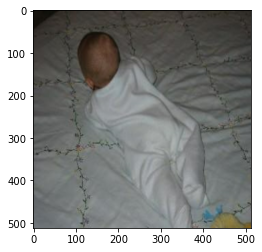

In [13]:
plt.imshow(sample_batch1[1])

In [30]:

gt1

<tf.Tensor: id=102, shape=(), dtype=string, numpy=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01\xd2\x00\x00\x01\xf4\x08\x03\x00\x00\x00\xbeK\\/\x00\x00\x03\x00PLTE\x00\x00\x00\x80\x00\x00\x00\x80\x00\x80\x80\x00\x00\x00\x80\x80\x00\x80\x00\x80\x80\x80\x80\x80@\x00\x00\xc0\x00\x00@\x80\x00\xc0\x80\x00@\x00\x80\xc0\x00\x80@\x80\x80\xc0\x80\x80\x00@\x00\x80@\x00\x00\xc0\x00\x80\xc0\x00\x00@\x80\x80@\x80\x00\xc0\x80\x80\xc0\x80@@\x00\xc0@\x00@\xc0\x00\xc0\xc0\x00@@\x80\xc0@\x80@\xc0\x80\xc0\xc0\x80\x00\x00@\x80\x00@\x00\x80@\x80\x80@\x00\x00\xc0\x80\x00\xc0\x00\x80\xc0\x80\x80\xc0@\x00@\xc0\x00@@\x80@\xc0\x80@@\x00\xc0\xc0\x00\xc0@\x80\xc0\xc0\x80\xc0\x00@@\x80@@\x00\xc0@\x80\xc0@\x00@\xc0\x80@\xc0\x00\xc0\xc0\x80\xc0\xc0@@@\xc0@@@\xc0@\xc0\xc0@@@\xc0\xc0@\xc0@\xc0\xc0\xc0\xc0\xc0 \x00\x00\xa0\x00\x00 \x80\x00\xa0\x80\x00 \x00\x80\xa0\x00\x80 \x80\x80\xa0\x80\x80`\x00\x00\xe0\x00\x00`\x80\x00\xe0\x80\x00`\x00\x80\xe0\x00\x80`\x80\x80\xe0\x80\x80 @\x00\xa0@\x00 \xc0\x00\xa0\xc0\x00 @\x8

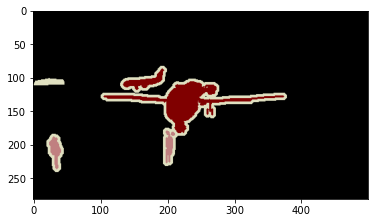

In [19]:
img.shape

TensorShape([281, 500, 3])

In [21]:
mask = img
height, width = mask.shape[:2]
segmentation_mask = np.zeros((height, width, len(VOC_COLORMAP)), dtype=np.float32)
for label_index, label in enumerate(VOC_COLORMAP):
#     print(label_index, label)
    segmentation_mask[:, :, label_index] = np.all(mask == label, axis=-1).astype(float)
#     return segmentation_mask

In [22]:
segmentation_mask.shape

(281, 500, 21)

In [23]:
def display_multiple_img(mask1, VOC_CLASSES, rows = 1, cols=1):
    figure, ax = plt.subplots(nrows=rows, ncols=cols)
    for label, i in zip(VOC_CLASSES, range(rows*cols)):
#         print(label)
        ax.ravel()[i].imshow(mask1[:,:,i], cmap='gray')
        ax.ravel()[i].set_title(label)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

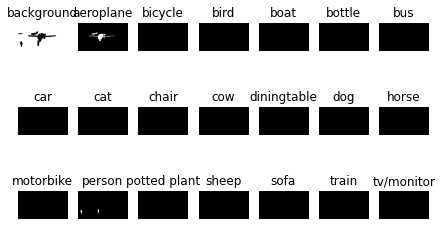

In [24]:
display_multiple_img(segmentation_mask, VOC_CLASSES, 3, 7)

In [14]:
gt_ds2 = configure_for_performance(gt_ds, batch_size=8, buffer_size=1024)
gt_ds2

<DatasetV1Adapter shapes: (None,), types: tf.string>

In [15]:
gt_ds3 = next(iter(gt_ds2))
gt_ds3

<tf.Tensor: id=139, shape=(8,), dtype=string, numpy=
array([b'/Users/gimbogeun/Downloads/DATASETS/VOCdevkit/VOC2012/SegmentationClass/2008_002073.png',
       b'/Users/gimbogeun/Downloads/DATASETS/VOCdevkit/VOC2012/SegmentationClass/2007_008140.png',
       b'/Users/gimbogeun/Downloads/DATASETS/VOCdevkit/VOC2012/SegmentationClass/2008_003913.png',
       b'/Users/gimbogeun/Downloads/DATASETS/VOCdevkit/VOC2012/SegmentationClass/2008_002080.png',
       b'/Users/gimbogeun/Downloads/DATASETS/VOCdevkit/VOC2012/SegmentationClass/2007_008815.png',
       b'/Users/gimbogeun/Downloads/DATASETS/VOCdevkit/VOC2012/SegmentationClass/2007_004009.png',
       b'/Users/gimbogeun/Downloads/DATASETS/VOCdevkit/VOC2012/SegmentationClass/2007_004476.png',
       b'/Users/gimbogeun/Downloads/DATASETS/VOCdevkit/VOC2012/SegmentationClass/2007_005296.png'],
      dtype=object)>

In [48]:
asd = tf.io.read_file(gt_ds3[0])
asd

<tf.Tensor: id=254, shape=(), dtype=string, numpy=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01\xf4\x00\x00\x01v\x08\x03\x00\x00\x00\xafp\x9ak\x00\x00\x03\x00PLTE\x00\x00\x00\x80\x00\x00\x00\x80\x00\x80\x80\x00\x00\x00\x80\x80\x00\x80\x00\x80\x80\x80\x80\x80@\x00\x00\xc0\x00\x00@\x80\x00\xc0\x80\x00@\x00\x80\xc0\x00\x80@\x80\x80\xc0\x80\x80\x00@\x00\x80@\x00\x00\xc0\x00\x80\xc0\x00\x00@\x80\x80@\x80\x00\xc0\x80\x80\xc0\x80@@\x00\xc0@\x00@\xc0\x00\xc0\xc0\x00@@\x80\xc0@\x80@\xc0\x80\xc0\xc0\x80\x00\x00@\x80\x00@\x00\x80@\x80\x80@\x00\x00\xc0\x80\x00\xc0\x00\x80\xc0\x80\x80\xc0@\x00@\xc0\x00@@\x80@\xc0\x80@@\x00\xc0\xc0\x00\xc0@\x80\xc0\xc0\x80\xc0\x00@@\x80@@\x00\xc0@\x80\xc0@\x00@\xc0\x80@\xc0\x00\xc0\xc0\x80\xc0\xc0@@@\xc0@@@\xc0@\xc0\xc0@@@\xc0\xc0@\xc0@\xc0\xc0\xc0\xc0\xc0 \x00\x00\xa0\x00\x00 \x80\x00\xa0\x80\x00 \x00\x80\xa0\x00\x80 \x80\x80\xa0\x80\x80`\x00\x00\xe0\x00\x00`\x80\x00\xe0\x80\x00`\x00\x80\xe0\x00\x80`\x80\x80\xe0\x80\x80 @\x00\xa0@\x00 \xc0\x00\xa0\xc0\x00 @\x80

In [16]:
gt_ds4 = gt_ds3.map(process_path)
gt_ds4

AttributeError: 'tensorflow.python.framework.ops.EagerTensor' object has no attribute 'map'

In [ ]:
gt_ds_processed = pa

In [32]:
gt_path = next(iter(gt_ds))

In [33]:
gt_path

<tf.Tensor: id=170, shape=(), dtype=string, numpy=b'/Users/gimbogeun/Downloads/DATASETS/VOCdevkit/VOC2012/SegmentationClass/2007_000032.png'>

In [34]:
# process_path(os.path.join(gt_dataset_path, gt1_name), img_size=[128,128])
gt_img = process_path(gt_path, img_size=[128,128])
gt_img

<tf.Tensor: id=180, shape=(128, 128, 3), dtype=float32, numpy=
array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]], dtype=float32)>

In [ ]:
file_path = next(iter(list_ds))
image, label = parse_image(file_path)

def show(image, label):
  plt.figure()
  plt.imshow(image)
  plt.title(label.numpy().decode('utf-8'))
  plt.axis('off')

show(image, label)

In [13]:
# tf.Tensor: id=1, shape=(), dtype=string, numpy=b'\xff\xd8\xff\xe0\ ...
# <tf.Tensor: id=4, shape=(500, 466, 3), dtype=uint8, numpy= array([[[ 95,  28,  11], ...
# <tf.Tensor: id=10, shape=(500, 466, 3), dtype=float32, numpy=array([[[0.37254903, 0.10980393, 0.04313726],
# <tf.Tensor: id=21, shape=(256, 256, 3), dtype=float32, numpy=array([[[0.36199272, 0.08055887, 0.06435176],

<tf.Tensor: id=21, shape=(256, 256, 3), dtype=float32, numpy=
array([[[0.36199272, 0.08055887, 0.06435176],
        [0.37642464, 0.09542428, 0.06835172],
        [0.3880608 , 0.11627211, 0.06881762],
        ...,
        [0.05245098, 0.11537058, 0.22265327],
        [0.0629902 , 0.12965687, 0.2353554 ],
        [0.0795184 , 0.14592466, 0.22163051]],

       [[0.3798236 , 0.08346941, 0.09915569],
        [0.38172036, 0.08423259, 0.10328896],
        [0.37205514, 0.08150408, 0.09821036],
        ...,
        [0.04938092, 0.11000307, 0.21833271],
        [0.06748849, 0.12631202, 0.24003752],
        [0.09410413, 0.16014273, 0.2346796 ]],

       [[0.35703424, 0.08731618, 0.09359981],
        [0.37030986, 0.08790092, 0.09860601],
        [0.37429607, 0.07950296, 0.09097733],
        ...,
        [0.04456225, 0.11122892, 0.21334217],
        [0.04836354, 0.11503021, 0.216991  ],
        [0.06207108, 0.11026348, 0.18437202]],

       ...,

       [[0.5165202 , 0.49946424, 0.44857275],
      

In [20]:
# 데이터 로드
image_count = len(list(glob.glob(os.path.join(image_dataset_path, '*.jpg'))))
image_count

2913

In [23]:
list_ds = tf.data.Dataset.list_files(os.path.join(image_dataset_path, '*.jpg'), shuffle=False)
list_ds

<DatasetV1Adapter shapes: (), types: tf.string>

In [28]:
list_ds1 = list_ds.map(process_path(None, [512, 512]))
list_ds1


ValueError: Attempt to convert a value (None) with an unsupported type (<class 'NoneType'>) to a Tensor.

In [39]:
list_ds2 = configure_for_performance(list_ds1, batch_size=8, buffer_size=-1)
list_ds2

<DatasetV1Adapter shapes: (None, 256, 256, 3), types: tf.float32>

In [44]:
sample_batch = iter(list_ds2)
sample_batch

In [45]:
sample_batch1 = next(sample_batch)
sample_batch1

<tf.Tensor: id=212, shape=(8, 256, 256, 3), dtype=float32, numpy=
array([[[[7.14602023e-02, 6.75386339e-02, 5.18523604e-02],
         [7.25898892e-02, 6.04652017e-02, 4.75132987e-02],
         [7.72926509e-02, 6.16063736e-02, 5.42449392e-02],
         ...,
         [3.50337029e-01, 3.45600992e-01, 2.97671586e-01],
         [3.33548307e-01, 3.36094230e-01, 2.86939323e-01],
         [5.59957325e-01, 5.63921630e-01, 5.35315037e-01]],

        [[6.61468506e-02, 6.09318800e-02, 5.69689609e-02],
         [7.88924322e-02, 6.67677373e-02, 6.16589747e-02],
         [8.13955888e-02, 6.57093152e-02, 6.17877468e-02],
         ...,
         [2.21134573e-01, 2.10467666e-01, 1.61585927e-01],
         [2.17705354e-01, 2.06325173e-01, 1.67372957e-01],
         [5.42262673e-01, 5.39104998e-01, 5.18351376e-01]],

        [[7.56348893e-02, 6.98555186e-02, 6.75857887e-02],
         [8.31316188e-02, 7.10069239e-02, 6.58981651e-02],
         [8.13530460e-02, 6.56667724e-02, 6.17452003e-02],
         ...,
   

In [29]:
def multiply(x, y):
    return x * y

l = list(map(multiply, [0, 1, 2, 3], [4, 5, 6, 7])) 
print(l) #[0, 5, 12, 21]

[0, 5, 12, 21]


In [40]:
for i in iter(list_ds2):
    print(i.)
    break

tf.Tensor(
[[[[5.82261048e-02 5.43045364e-02 3.46966945e-02]
   [7.76480883e-02 7.37265199e-02 5.41186817e-02]
   [7.27949589e-02 6.88733906e-02 4.92655486e-02]
   ...
   [9.34436359e-03 9.34436359e-03 9.34436359e-03]
   [7.84313772e-03 7.84313772e-03 7.84313772e-03]
   [4.35593585e-03 4.35593585e-03 4.35593585e-03]]

  [[6.28150553e-02 5.88934869e-02 3.92856412e-02]
   [7.93551058e-02 7.54335374e-02 5.58256879e-02]
   [7.75582120e-02 7.36366436e-02 5.40288016e-02]
   ...
   [9.34436359e-03 9.34436359e-03 9.34436359e-03]
   [1.05775129e-02 1.05775129e-02 1.05775129e-02]
   [8.52481648e-03 8.52481648e-03 8.52481648e-03]]

  [[6.36140183e-02 5.96924424e-02 4.00846004e-02]
   [8.43214467e-02 8.03998783e-02 6.07920364e-02]
   [7.43472278e-02 7.04256594e-02 5.08178137e-02]
   ...
   [1.17647070e-02 1.17647070e-02 1.17647070e-02]
   [1.17647070e-02 1.17647070e-02 1.17647070e-02]
   [1.14319455e-02 1.14319455e-02 1.14319455e-02]]

  ...

  [[6.03035167e-02 6.42250851e-02 4.09986302e-02]
   [1

In [32]:
train_len = tf.data.experimental.cardinality(list_ds).numpy()
print(train_len)

2913


In [ ]:
list

In [37]:
def process_path(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [256, 256])
    return img

In [ ]:
                  
                  
list_ds = tf.data.Dataset.list_files(str(data_dir+"/*"), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)
list_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [33]:
def configure_for_performance(ds, batch_size, buffer_size):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1024)
    ds = ds.batch(batch_size, drop_remainder=False)
    ds = ds.prefetch(buffer_size=buffer_size)
    return ds
	
def process_path(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32) * 2 - 1
    img = tf.image.resize(img, [img_h, img_w])
    return img

train_ds = configure_for_performance(train_ds, batch_size, buffer_size)


In [ ]:
import sys, os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]='0'

import tensorflow as tf
import numpy as np
import glob
import pathlib
import matplotlib.pyplot as plt
import PIL

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

print('''+++ env info +++
Python version : {},
Tensorflow version : {},
Keras version : {}
'''.format(sys.version, tf.__version__, tf.keras.__version__))

print('TF GPU available test :', tf.config.list_physical_devices('GPU'))
#print(tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None))
# os.environ["CUDA_VISIBLE_DEVICES"]="1"

from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, GaussianNoise
from tensorflow.keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import LeakyReLU, ReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import losses
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image
import tensorflow.keras.backend as K
from tensorflow.keras.utils import plot_model

def configure_for_performance(ds, batch_size, buffer_size):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1024)
    ds = ds.batch(batch_size, drop_remainder=False)
    ds = ds.prefetch(buffer_size=buffer_size)
    return ds
	
def process_path(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32) * 2 - 1
    img = tf.image.resize(img, [img_h, img_w])
    return img

	
local_shape, global_shape = (64,64,3), (128,128,3)

img_h, img_w, channel = 128, 128, 3
inpainted_h, inpainted_w = 64, 64

batch_size = 16
AUTOTUNE = tf.data.experimental.AUTOTUNE
buffer_size = AUTOTUNE
epochs = 60000
sample_interval = 10

margin = 5
patch_size = 64

#data_dir = '/home/user_5/bg/python/GDL_code/data/celeb/img_align_celeba/img_align_celeba'
data_dir = '/home/user_5/bg/datasets/sample'
save_path = 'GL_celeb_7'

# 데이터 로드
image_count = len(list(glob.glob(data_dir+'/*.jpg')))
list_ds = tf.data.Dataset.list_files(str(data_dir+"/*"), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)
list_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

val_size = int(image_count * 0.01)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

train_len = tf.data.experimental.cardinality(train_ds).numpy()
val_len = tf.data.experimental.cardinality(val_ds).numpy()
print(train_len)
print(val_len)

train_ds = configure_for_performance(train_ds, batch_size, buffer_size)
val_ds = configure_for_performance(val_ds, batch_size, buffer_size)

for i in iter(train_ds):
    sample = i
    break
	
result, padded, coord, pad_size = block_patch(sample, mode='random_box', patch_size=patch_size, margin=margin)
											  
plt.figure(figsize=(10, 5))
for i in range(6):
    ax = plt.subplot(2,3,i+1)
    plt.imshow(result[i].numpy()*0.5+0.5)
    plt.axis("off")
#plt.close()


In [25]:
# 3. decode 함수 선언
def decode_img(image, label):
    x = tf.io.read_file(image) # file read 
    x = tf.image.decode_jpeg(x, channels=3) # 컬러 이미지라면 channels=3, 흑백이라면 channels=1
    x = tf.image.convert_image_dtype(x, tf.float32)
    x = tf.image.resize(x, img_size) # 이미지 크기를 resize

    y = tf.one_hot(label, depth=num_classes),
    
    return x, y

In [ ]:
x = tf.io.read_file(image) # file read 
x = tf.image.decode_jpeg(x, channels=3) # 컬러 이미지라면 channels=3, 흑백이라면 channels=1
x = tf.image.convert_image_dtype(x, tf.float32)
x = tf.image.resize(x, img_size) # 이미지 크기를 resize

(500, 466, 3)


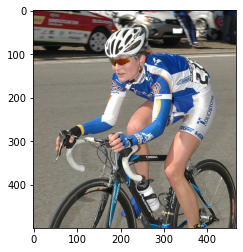

In [5]:
img_show(img1_path)

(500, 466, 3)


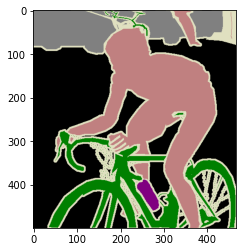

In [6]:
img_show(gt1_path)

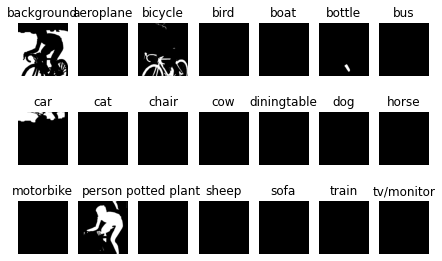

In [36]:
gt1_cv2 = cv2.imread(gt1_path)
mask = cv2.cvtColor(gt1_cv2, cv2.COLOR_BGR2RGB)
height, width = mask.shape[:2]
segmentation_mask = np.zeros((height, width, len(VOC_COLORMAP)), dtype=np.float32)
for label_index, label in enumerate(VOC_COLORMAP):
#     print(label_index, label)
    segmentation_mask[:, :, label_index] = np.all(mask == label, axis=-1).astype(float)
display_multiple_img(segmentation_mask, VOC_CLASSES, 3, 7)

In [22]:
segmentation_mask.shape

(500, 466, 21)

In [38]:
gt_path = os.path.join(gt_dataset_path, os.listdir(gt_dataset_path)[0])
seg_mask = mk_seg_mask(gt_path, VOC_COLORMAP)

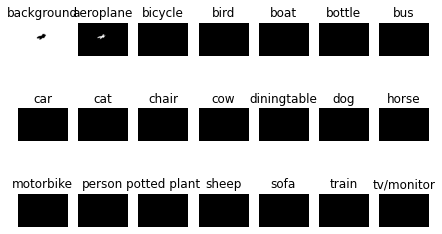

In [40]:
display_multiple_img(seg_mask, VOC_CLASSES, 3, 7)

In [41]:
seg_mask.shape

(333, 500, 21)